In [38]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
sw = stopwords.words('english')

In [40]:
tweets = pd.read_csv('data/tweet_tweet.csv')
tweets.shape

(9093, 3)

In [41]:
tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [42]:
tweets.rename(
    columns={
        'tweet_text': 'body',
        'emotion_in_tweet_is_directed_at': 'product',
        'is_there_an_emotion_directed_at_a_brand_or_product': 'target'
    },
    inplace=True
)

In [43]:
tweets.head()

,body,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Building a Binary target

In [44]:
binary_df = tweets.copy()

In [45]:
binary_df

,body,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [46]:
binary_df.iloc[3]

body       @sxsw I hope this year's festival isn't as cra...
product                                   iPad or iPhone App
target                                      Negative emotion
Name: 3, dtype: object

In [47]:
binary_df['target'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: target, dtype: int64

In [48]:
binary_df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

Of the 9,000 records, a majority are related to Apple vs Google.

In [49]:
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   body     9092 non-null   object
 1   product  3291 non-null   object
 2   target   9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


After exploring the data, we want to fill in the product column nulls based upon the body of the tweet.

In [50]:
# binary_df['product'] = binary_df['product'].fillna(value='poop')

In [51]:
binary_df = binary_df.apply(lambda x: x.astype(str).str.lower())
binary_df['body'] = binary_df['body'].str.replace(r'[^\w\s]+', '')
binary_df['body'] = binary_df['body'].str.replace(r'\d+', '')
binary_df.body = binary_df.body.apply(lambda x: x.split())
binary_df

/var/folders/75/zphbcbg1741c1vvlwtdrm1q80000gn/T/ipykernel_64132/2014105837.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  binary_df['body'] = binary_df['body'].str.replace(r'[^\w\s]+', '')
/var/folders/75/zphbcbg1741c1vvlwtdrm1q80000gn/T/ipykernel_64132/2014105837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  binary_df['body'] = binary_df['body'].str.replace(r'\d+', '')


,body,product,target
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",iphone,negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipad...",ipad or iphone app,positive emotion
2,"[swonderlin, can, not, wait, for, ipad, also, ...",ipad,positive emotion
3,"[sxsw, i, hope, this, years, festival, isnt, a...",ipad or iphone app,negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,positive emotion
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",ipad,positive emotion
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",nan,no emotion toward brand or product
9090,"[googles, zeiger, a, physician, never, reporte...",nan,no emotion toward brand or product
9091,"[some, verizon, iphone, customers, complained,...",nan,no emotion toward brand or product


In [52]:
apple_words = ['apple', 'ipad', 'iphone', 'mac', 'ios']
google_words = ['google', 'android', 'pixel']

def is_apple(x):
    for i in apple_words:
        for j in x:
            if i.lower() in j.lower():
                return 'apple'
            else:
                continue

    
def is_google(x):
    for i in google_words:
        for j in x:
            if i.lower() in j.lower():
                return 'google'
            else:
                continue

 

In [53]:
binary_df['company'] = binary_df.body.apply(is_apple)
binary_df['google'] = binary_df.body.apply(is_google)
binary_df['company'] = binary_df['company'].combine_first(binary_df['google'])
binary_df.drop(columns=['google', 'product'], inplace=True)
binary_df

,body,target,company
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",negative emotion,apple
1,"[jessedee, know, about, fludapp, awesome, ipad...",positive emotion,apple
2,"[swonderlin, can, not, wait, for, ipad, also, ...",positive emotion,apple
3,"[sxsw, i, hope, this, years, festival, isnt, a...",negative emotion,apple
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",positive emotion,google
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",positive emotion,apple
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",no emotion toward brand or product,google
9090,"[googles, zeiger, a, physician, never, reporte...",no emotion toward brand or product,google
9091,"[some, verizon, iphone, customers, complained,...",no emotion toward brand or product,apple


In [54]:
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   body     9093 non-null   object
 1   target   9093 non-null   object
 2   company  8313 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [55]:
binary_df.dropna(inplace=True)
binary_df = binary_df[binary_df.target != "i can't tell"]
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8163 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   body     8163 non-null   object
 1   target   8163 non-null   object
 2   company  8163 non-null   object
dtypes: object(3)
memory usage: 255.1+ KB


In [56]:
label_enc = LabelEncoder()
binary_df.target = label_enc.fit_transform(binary_df.target)
binary_df

/var/folders/75/zphbcbg1741c1vvlwtdrm1q80000gn/T/ipykernel_64132/140410024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_df.target = label_enc.fit_transform(binary_df.target)


,body,target,company
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",0,apple
1,"[jessedee, know, about, fludapp, awesome, ipad...",2,apple
2,"[swonderlin, can, not, wait, for, ipad, also, ...",2,apple
3,"[sxsw, i, hope, this, years, festival, isnt, a...",0,apple
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",2,google
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",2,apple
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",1,google
9090,"[googles, zeiger, a, physician, never, reporte...",1,google
9091,"[some, verizon, iphone, customers, complained,...",1,apple


In [57]:
X = binary_df.body
y = binary_df.target

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



#### AND THIS IS THE PART THAT DOESN'T WORK

Need to lowercase and strip punctuation.
Non-unique tweets, string index comparison.

In [59]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ashlidougherty/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ashlidougherty/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/ashlidougherty/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ashlidougherty/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [60]:
# making a copy, dropping nulls, reset index
corpus = binary_df.copy()
corpus.reset_index()
corpus

,body,target,company
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",0,apple
1,"[jessedee, know, about, fludapp, awesome, ipad...",2,apple
2,"[swonderlin, can, not, wait, for, ipad, also, ...",2,apple
3,"[sxsw, i, hope, this, years, festival, isnt, a...",0,apple
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",2,google
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",2,apple
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",1,google
9090,"[googles, zeiger, a, physician, never, reporte...",1,google
9091,"[some, verizon, iphone, customers, complained,...",1,apple


In [61]:
# lowercase for reasons
corpus.company = corpus.company.apply(lambda x: x.lower())

# POS tagging via pos_tag and custom function
corpus.body = corpus.body.apply(lambda x: pos_tag(x))

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# I heard that putting custom functions inside of list comps inside of lambdas was very pythonic
corpus.body = corpus.body.apply(lambda row: [(x[0], get_wordnet_pos(x[1])) for x in row])

corpus

,body,target,company
0,"[(wesley, n), (i, n), (have, v), (a, n), (g, n...",0,apple
1,"[(jessedee, n), (know, v), (about, n), (fludap...",2,apple
2,"[(swonderlin, n), (can, n), (not, r), (wait, v...",2,apple
3,"[(sxsw, n), (i, n), (hope, v), (this, n), (yea...",0,apple
4,"[(sxtxstate, n), (great, a), (stuff, n), (on, ...",2,google
...,...,...,...
9088,"[(ipad, n), (everywhere, r), (sxsw, a), (link,...",2,apple
9089,"[(wave, n), (buzz, n), (rt, n), (mention, n), ...",1,google
9090,"[(googles, n), (zeiger, v), (a, n), (physician...",1,google
9091,"[(some, n), (verizon, n), (iphone, n), (custom...",1,apple


In [62]:
# lemmatizing things, for reasons
lemmatizer = nltk.stem.WordNetLemmatizer()
corpus.body = corpus.body.apply(lambda row: [lemmatizer.lemmatize(x[0]) for x in row])

#show me the money
corpus

,body,target,company
0,"[wesley, i, have, a, g, iphone, after, hr, twe...",0,apple
1,"[jessedee, know, about, fludapp, awesome, ipad...",2,apple
2,"[swonderlin, can, not, wait, for, ipad, also, ...",2,apple
3,"[sxsw, i, hope, this, year, festival, isnt, a,...",0,apple
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",2,google
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",2,apple
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",1,google
9090,"[google, zeiger, a, physician, never, reported...",1,google
9091,"[some, verizon, iphone, customer, complained, ...",1,apple


In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [ ]:
#0 = negative
#1 = neutral
#2 = positive 

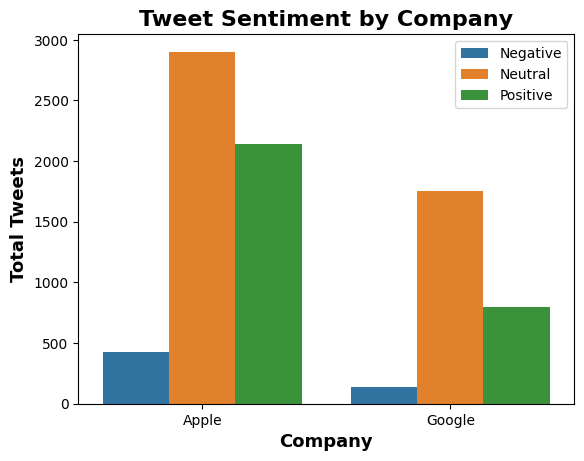

In [84]:
sns.countplot(x='company', hue = 'target', data=binary_df)
plt.ylabel('Total Tweets', weight = 'bold', size = 13)
plt.xlabel('Company',weight = 'bold', size = 13 )
plt.xticks(ticks = [0,1], labels = ['Apple', 'Google'] )
plt.title('Tweet Sentiment by Company', weight = 'bold', size = 16)
plt.legend(['Negative', 'Neutral', 'Positive']);

In [75]:
binary_df.target.value_counts()

1    4654
2    2940
0     569
Name: target, dtype: int64

In [26]:
corpus.target.value_counts()

1    4654
2    2940
0     569
Name: target, dtype: int64

In [27]:
corpus = corpus[corpus.target != "i can't tell"]
corpus.target.value_counts()

1    4654
2    2940
0     569
Name: target, dtype: int64

In [28]:
corpus.to_csv('data/cleaned.csv')

In [29]:
lemmed_b ow = []
for row in corpus.body:
    for lemma in row:
        lemmed_bow.append(lemma)

print(f'There are {len(set(lemmed_bow))} unique lemmas.')

There are 9212 unique lemmas.


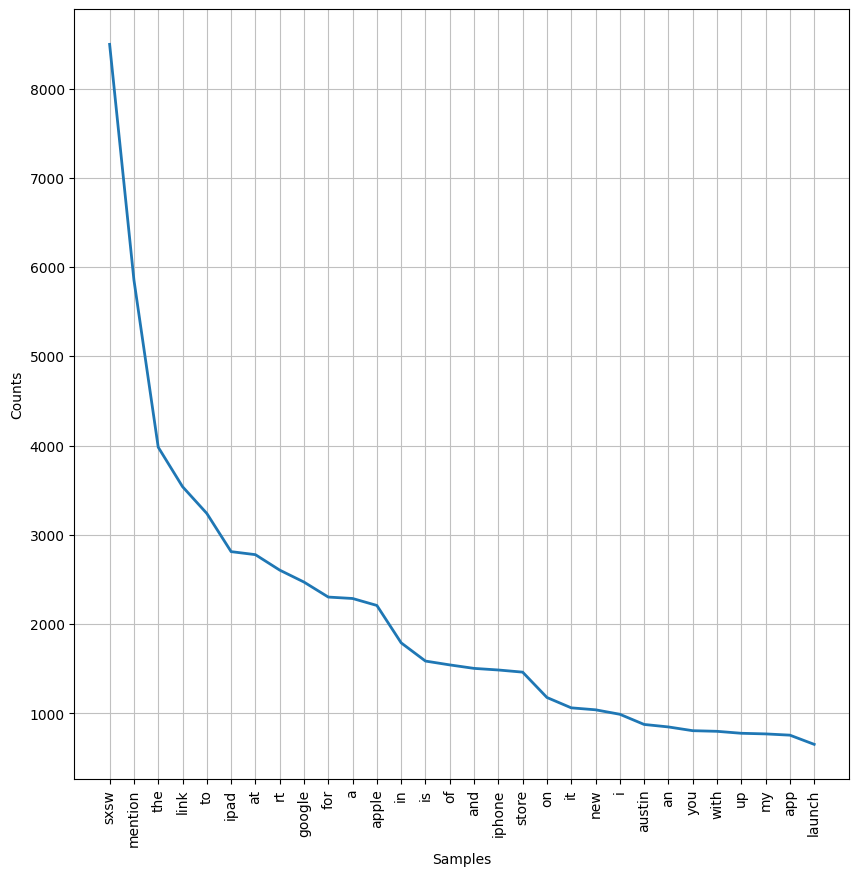

In [30]:
fdist = FreqDist(lemmed_bow)
plt.figure(figsize=(10, 10))
fdist.plot(30)
labels = len(set(lemmed_bow))
# ax = plt.gca()
# ax.set_xticklabels(labels=labels, rotation=45);

#### how pretty, a graph

In [31]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw,
                      ngram_range=[1, 2])

X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv.head()

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
tf_vec = TfidfVectorizer(
    token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
    stop_words=sw,
)

X = tf_vec.fit_transform(corpus.body)

df_tf = pd.DataFrame(X.toarray(), columns=tf_vec.get_feature_names())
df_tf.head()

In [ ]:
df_cv.iloc[1000].sort_values(ascending=False)[:10]

In [ ]:
df_tf.iloc[1000].sort_values(ascending=False)[:10]

In [ ]:
tf_vec.vocabulary_